# Demo: Custom observation types
In this demo, you can find a demonstration on how to use Observation types.

In [1]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #else the legend is cutoff in ipython inline plots

In [2]:
import metobs_toolkit

#Initialize an empty Dataset
your_dataset = metobs_toolkit.Dataset()

## Default observation types

An observation record must always be linked to an *observation type* which is specified by the ``Obstype`` class. 
An Obstype represents one observation type (i.g. temperature), and it handles unit conversions and string representations of an observation type. 

By default, a set of standard observationtypes are stored in a Dataset:

In [3]:
your_dataset.show()

--------  General --------- 

Empty instance of Dataset

 --------  Observation types --------- 

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Fahrenheit': ['fahrenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Fahrenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.
humidity observation with: 
     * standard unit: % 
     * data column as None in None 
     * known units and aliases: {'%': ['percent', 'percentage']} 
     * description: 2m - relative humidity 
     * conversions to known units: {} 
     * originates from data column: None with None as native unit.
radiation_temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius

From the output it is clear that an Obstype holds a **standard unit**. This standard unit is the preferred unit to store and visualize the data in. The toolkit will convert all observations to their standard unit, on all import methods. *(This is also true for the Modeldata, which is converted to the standard units upon import)*.

A **description** (optional) holds a more detailed description of the observation type. 

Multiple **known units** can be defined, as long as the conversion to the standard unit is defined. 

**Aliases** are equivalent names for the same unit. 

At last, each Obstype has a unique **name** for convenions. You can use this name to refer to the Obstype in the Dataset methods.

As an example take a look at the temperature observation and see what the standard unit, other units and aliases look like:


In [4]:
temperature_obstype = your_dataset.obstypes['temp'] #temp is the name of the observationtype
print(temperature_obstype)

temperature_obstype.get_info()

Obstype instance of temp
temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Fahrenheit': ['fahrenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Fahrenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.


## Creating and Updating observations
If you want to create a new observationtype you can do this by creating an Obstype and adding it to your (empty) Dataset:

In [5]:
co2_concentration = metobs_toolkit.Obstype(obsname='co2',
                                           std_unit='ppm')

#add other units to it (if needed)
co2_concentration.add_unit(unit_name='ppb',
                           conversion=['x / 1000'], #1 ppb = 0.001 ppm
                          )

#Set a description
co2_concentration.set_description(desc='The CO2 concentration measured at 2m above surface')

#add it to your dataset
your_dataset.add_new_observationtype(co2_concentration)

#You can see the CO2 concentration is now added to the dataset
your_dataset.show()
                                           

--------  General --------- 

Empty instance of Dataset

 --------  Observation types --------- 

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Fahrenheit': ['fahrenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Fahrenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.
humidity observation with: 
     * standard unit: % 
     * data column as None in None 
     * known units and aliases: {'%': ['percent', 'percentage']} 
     * description: 2m - relative humidity 
     * conversions to known units: {} 
     * originates from data column: None with None as native unit.
radiation_temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius

You can also update (the units) of the know observationtypes :

In [6]:
your_dataset.add_new_unit(obstype = 'temp', 
                          new_unit= 'your_new_unit',
                          conversion_expression = ['x+3', 'x * 2'])
# The conversion means: 1 [your_new_unit] = (1 + 3) * 2 [°C]
your_dataset.obstypes['temp'].get_info()

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Fahrenheit': ['fahrenheit'], 'your_new_unit': []} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Fahrenheit': ['x-32.0', 'x/1.8'], 'your_new_unit': ['x+3', 'x * 2']} 
     * originates from data column: None with None as native unit.


## Obstypes for Modeldata
### ModelObstype
An extension to the `Obstype` class is the `ModelObstype` class which is used for interacting with GEE dataset. In addition to a regular `Obstype` a `ModelObstype` contains the info which band (of the GEE dataset) represents the observation, and handles the unit conversion. 

*Note:* All methods that work on `Obstype` do also work on `ModelObstype`.


A `ModelObstype` is specific to one GEE dataset. Therefore the known modelobstypes are stored in each `GeeDynamicModelData`. As a default, there is an ERA5-land `GeeDynamicModelData` stored in all Datasets.

In [7]:
your_dataset.gee_datasets

{'lcz': GeeStaticModelData instance of lcz  (no metadata has been set) ,
 'altitude': GeeStaticModelData instance of altitude  (no metadata has been set) ,
 'worldcover': GeeStaticModelData instance of worldcover  (no metadata has been set) ,
 'ERA5-land': Empty GeeDynamicModelData instance of ERA5-land }

In [8]:
era5_model = your_dataset.gee_datasets['ERA5-land']
era5_model

Empty GeeDynamicModelData instance of ERA5-land 

To see all the known `ModelObstypes` of the era5_model, we can look in the attribute or use the `GeeDynamicModelData.get_info()` method. 

In [9]:
print(era5_model.modelobstypes)
# or
era5_model.get_info()

{'temp': ModelObstype instance of temp (linked to band: temperature_2m), 'pressure': ModelObstype instance of pressure (linked to band: surface_pressure), 'wind': ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m)}
Empty GeeDynamicModelData instance of ERA5-land 
------ Details --------- 

 * name: ERA5-land
 * location: ECMWF/ERA5_LAND/HOURLY
 * value_type: numeric
 * scale: 2500
 * is_static: False
 * is_image: False
 * is_mosaic: False
 * credentials: 
 * time res: 1h

 -- Known Modelobstypes -- 

 * temp : ModelObstype instance of temp (linked to band: temperature_2m)
    (conversion: Kelvin --> Celsius)
 * pressure : ModelObstype instance of pressure (linked to band: surface_pressure)
    (conversion: pa --> pa)
 * wind : ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m)
    vectorfield that will be converted to: 
      * wind_speed
      * wind_direction
  

As an example, we will create a new ModelObstype that represents the accumulated precipitation as is present in the ERA5_land GEE dataset. We extract precipitation timeseries as a demo.

In [10]:
import pandas as pd
from datetime import datetime
#Create a new observation type
precipitation = metobs_toolkit.Obstype(obsname='cumulated_precip',
                                      std_unit='m',
                                      description='Cumulated total precipitation since midnight per squared meter')

#Create the ModelObstype
precip_in_era5 = metobs_toolkit.ModelObstype(
                        obstype=precipitation,
                        model_band='total_precipitation', #look this up: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY#bands 
                        model_unit='m',
               )
# Add it to the ERA5 model
era5_model.add_modelobstype(precip_in_era5)

era5_model.modelobstypes


{'temp': ModelObstype instance of temp (linked to band: temperature_2m),
 'pressure': ModelObstype instance of pressure (linked to band: surface_pressure),
 'wind': ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m),
 'cumulated_precip': ModelObstype instance of cumulated_precip (linked to band: total_precipitation)}

In [11]:

# import metadata in your dataset 
your_dataset.import_data_from_file(
                input_data_file=metobs_toolkit.demo_datafile,
                input_metadata_file=metobs_toolkit.demo_metadatafile,
                template_file=metobs_toolkit.demo_template)
metadf = your_dataset.metadf
metadf


Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.


Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.


Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.


Rukwind is present in the datafile, but not found in the template! This column will be ignored.


Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.


Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.


The following columns are found in the metadata, but not in the template and are therefore ignored: 
['sponsor', 'benaming', 'stad', 'Network']


,lat,lon,school,geometry,dataset_resolution,dt_start,dt_end
name,,,,,,,
vlinder01,50.980438,3.815763,UGent,POINT (3.81576 50.98044),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder02,51.022379,3.709695,UGent,POINT (3.7097 51.02238),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder03,51.324583,4.952109,Heilig Graf,POINT (4.95211 51.32458),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder04,51.335522,4.934732,Heilig Graf,POINT (4.93473 51.33552),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder05,51.052655,3.675183,Sint-Barbara,POINT (3.67518 51.05266),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder06,51.027100,4.516300,BimSem,POINT (4.5163 51.0271),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder07,51.030889,4.478445,PTS,POINT (4.47844 51.03089),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder08,51.028130,4.477398,TSM,POINT (4.4774 51.02813),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder09,50.927167,4.075722,SMI,POINT (4.07572 50.92717),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00


In [12]:

# Now we add the metadata to the model 
era5_model.set_metadf(metadf)

# Define a time period
tstart = datetime(2023,1,12)
tend = datetime(2023,1,15)


#Extract timeseries data at the location of the stations
era5_model.extract_timeseries_data(
                    obstypes=['cumulated_precip'],
                    startdt_utc=tstart,
                    enddt_utc=tend)
                

era5_model.get_info()


GeeDynamicModelData instance of ERA5-land with modeldata 
------ Details --------- 

 * name: ERA5-land
 * location: ECMWF/ERA5_LAND/HOURLY
 * value_type: numeric
 * scale: 2500
 * is_static: False
 * is_image: False
 * is_mosaic: False
 * credentials: 
 * time res: 1h

 -- Known Modelobstypes -- 

 * temp : ModelObstype instance of temp (linked to band: temperature_2m)
    (conversion: Kelvin --> Celsius)
 * pressure : ModelObstype instance of pressure (linked to band: surface_pressure)
    (conversion: pa --> pa)
 * wind : ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m)
    vectorfield that will be converted to: 
      * wind_speed
      * wind_direction
    (conversion: m/s --> m/s)
 * cumulated_precip : ModelObstype instance of cumulated_precip (linked to band: total_precipitation)
    (conversion: m --> m)

 -- Metadata -- 

                lon        lat                  geometry
name                                

In [13]:
era5_model.modeldf

cumulated_precip
name      datetime                                   
vlinder01 2023-01-12 00:00:00+00:00          0.005562
          2023-01-12 01:00:00+00:00          0.000683
          2023-01-12 02:00:00+00:00          0.001521
          2023-01-12 03:00:00+00:00          0.002712
          2023-01-12 04:00:00+00:00          0.004521
...                                               ...
vlinder28 2023-01-14 20:00:00+00:00          0.010108
          2023-01-14 21:00:00+00:00          0.010191
          2023-01-14 22:00:00+00:00          0.010281
          2023-01-14 23:00:00+00:00          0.010303
          2023-01-15 00:00:00+00:00          0.010307

[2044 rows x 1 columns]

colormap: tab20, is not well suited to color 28 categories.


<Axes: title={'center': 'ERA5-land'}, ylabel='cumulated_precip (m)\n originates from total_precipitation'>

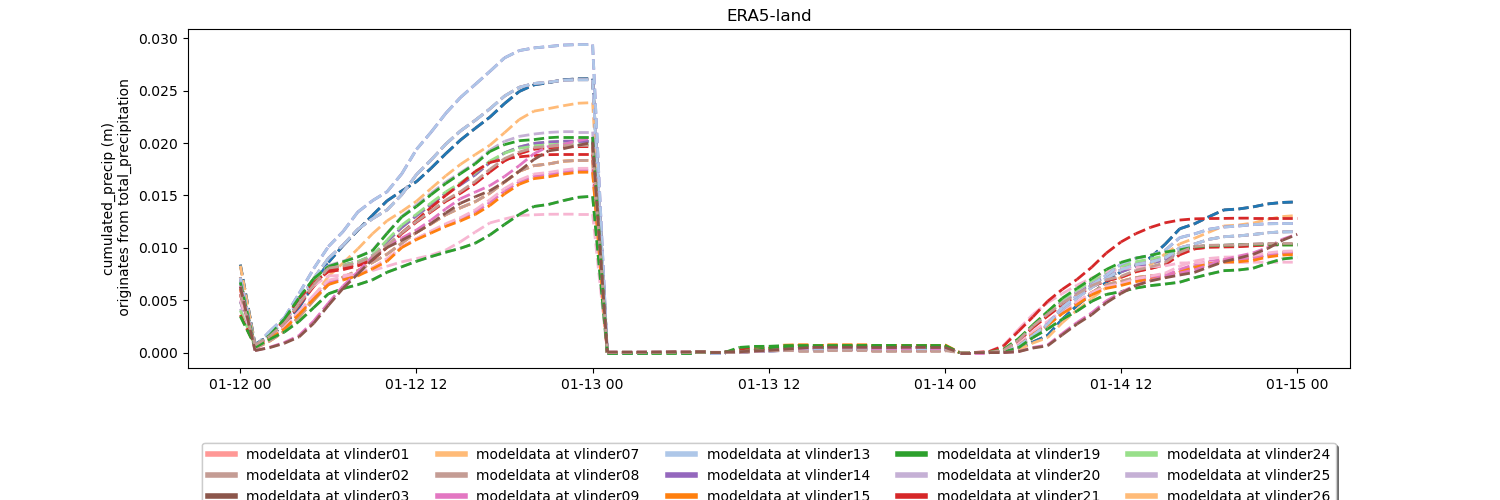

In [14]:
era5_model.make_plot(obstype_model='cumulated_precip')

### ModelObstype_Vectorfield
At a specific height, the wind can be seen (by approximation) as a 2D vector field. The vector components are often stored in different bands/variables in a model.

For example, if you want the 10m windspeed from ERA5 you cannot find a band for the windspeed. There are bands for the
u and v component of the wind. 

The `ModelObstype_Vectorfield` class represents a modelobstype, for which there does not exist a band, but can be constructed from (orthogonal) components. The vector amplitudes and direction are computed, and the corresponding `ModelObstype`'s are created.

By default, the *wind* is added as a `ModelObstype_vectorfield` for the ERA5-land `GeeDynamicModelData`.

In [15]:
era5_model.modelobstypes

{'temp': ModelObstype instance of temp (linked to band: temperature_2m),
 'pressure': ModelObstype instance of pressure (linked to band: surface_pressure),
 'wind': ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m),
 'cumulated_precip': ModelObstype instance of cumulated_precip (linked to band: total_precipitation)}

So we can see that *wind* corresponds with two bands (the u and v component).

When extracting the wind data from era5 it will
 1. Download the u and v wind components for your period and locations.
 2. Convert each component to its standard units (m/s for the wind components).
 3. Compute the amplitude and the direction (in degrees from North, clockwise).
 4. Add a `ModelObstype` for the amplitude and one for the direction.

In [16]:
era5_model.set_metadf(metadf)

tstart = datetime(2023,1,12)
tend = datetime(2023,1,15)

era5_model.extract_timeseries_data(
                    obstypes=['wind'],
                    startdt_utc=tstart,
                    enddt_utc=tend)
                

era5_model.modelobstypes


{'temp': ModelObstype instance of temp (linked to band: temperature_2m),
 'pressure': ModelObstype instance of pressure (linked to band: surface_pressure),
 'wind': ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m),
 'cumulated_precip': ModelObstype instance of cumulated_precip (linked to band: total_precipitation),
 'wind_speed': ModelObstype instance of wind_speed (linked to band: wind_speed),
 'wind_direction': ModelObstype instance of wind_direction (linked to band: wind_direction)}

We can see that *wind_speed* and *wind_direction* are added to the known modelobstypes of the era5_model. The modeldata contains these columns.

In [17]:
era5_model.modeldf

wind_speed  wind_direction
name      datetime                                             
vlinder01 2023-01-12 00:00:00+00:00    7.106595       46.536068
          2023-01-12 01:00:00+00:00    6.949550       41.268541
          2023-01-12 02:00:00+00:00    7.525815       36.742786
          2023-01-12 03:00:00+00:00    8.228055       35.152447
          2023-01-12 04:00:00+00:00    9.269519       35.976802
...                                         ...             ...
vlinder28 2023-01-14 20:00:00+00:00    5.479666       72.230140
          2023-01-14 21:00:00+00:00    5.383347       71.073569
          2023-01-14 22:00:00+00:00    5.259395       68.598149
          2023-01-14 23:00:00+00:00    5.251348       65.927332
          2023-01-15 00:00:00+00:00    5.248973       65.783229

[2044 rows x 2 columns]

colormap: tab20, is not well suited to color 28 categories.


<Axes: title={'center': 'ERA5-land'}, ylabel='wind_speed (m/s)\n originates from wind_speed'>

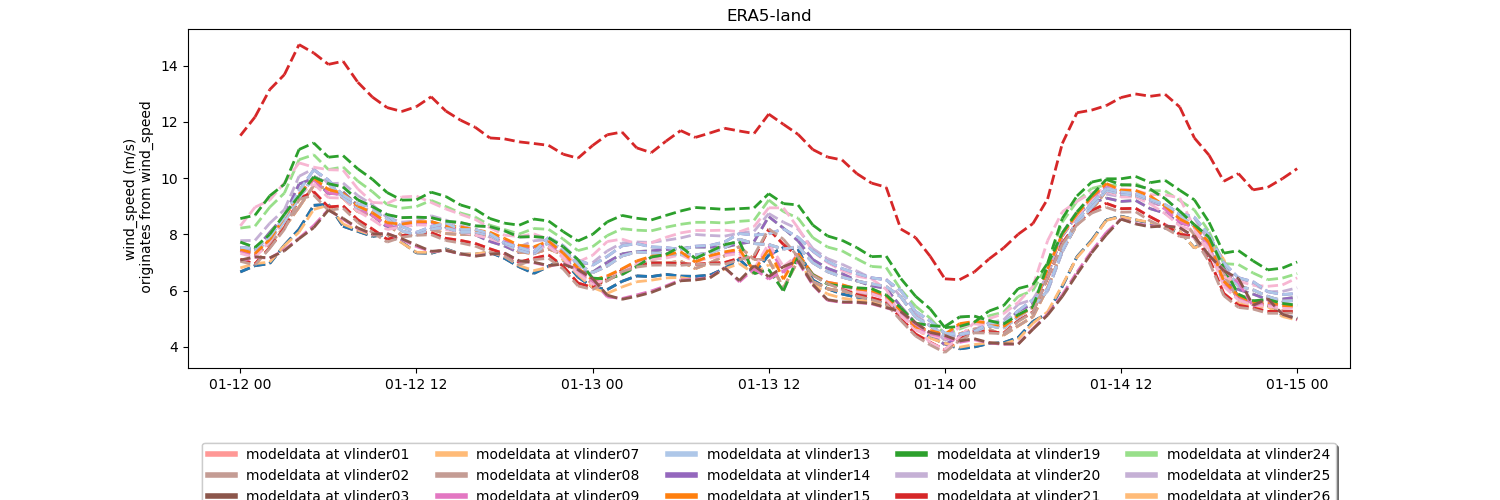

In [18]:
era5_model.make_plot(obstype_model='wind_speed')